----------

---------

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Загрузка данных

In [2]:
gym = pd.read_csv('/datasets/gym_churn.csv')
gym.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


# 2. Исследовательский анализ данных (EDA)

In [3]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В исходной таблице 14 столбцов и 4000 строк. 10 столбцов в формате integer, 4 столбца в формате float

In [4]:
#проверка на пропущенные значения
gym.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

В таблице отсутствуют пропущенные значения

In [5]:
#проверка на наличие дубоикатов
gym.duplicated().sum()

0

В таблице отсутствуют дубликаты

In [6]:
gym.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


1. Стандартное отклонение по суммарной выручке от других услуг фитнес-центра составляет 96. Это достаточно большой разброс. Можем сделать вывод о разрозренности клиентов. Часть готова покупать услуги выше среднего значения(147)
2. Стандартное отклонение по лайфтайму клиентов выше, чем его среднее значение(3.75 против 3.73). Есть большое количество клиентов, у которых лайфтайм не превышает 3 месяцев, но также есть и супер лояльные клиенты.
3. Более половины клиентов не посещает фитнес-центр более двух раз в неделю, при этом за предыдущий месяц наблюдается некоторое снижение по посещаемости в сравнении за весь период(среднее значение посещений: 1.77 против 1.88 раз в неделю)

## Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [7]:
#фильтрация по клиентам, которые ушли в отток
churn_yes = gym.query('Churn == 1')
#фильтрация по клиентам, которые не ушли в отток
churn_not = gym.query('Churn == 0')

In [8]:
churn_yes.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [9]:
churn_not.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882


По тем кто остался мы видим, что это  чаще всего сотрудники компании-партнёра клуба, которые пришли по факту первоначальной записи в рамках акции «приведи друга». Также у них срок абонемента в среднем равен 6 месяцам против 2 у тех, кто ушел в отток. Также они чаще посещают групповые занятия и в среднем больше тратят от других услуг фитнес-центра(159 против 115). Они более лояльные клиенты: их лайфтайм равен 5 месяцам , и они в два раза чаще в неделю посещают фитнес-центр

----------
<font color="green">

## Комментарий от наставника

С первым шагом работы ты справился просто отлично! Даже на некоторый след сумел напасть)<p>
Посмотрим, что с гистограммами.
    
</font>

## Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

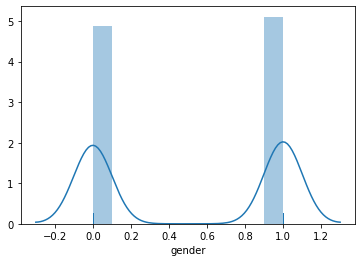

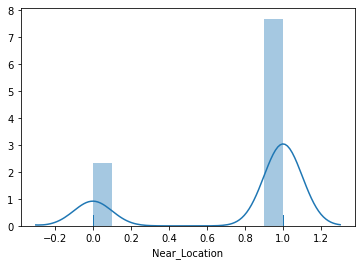

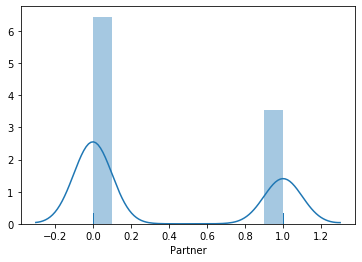

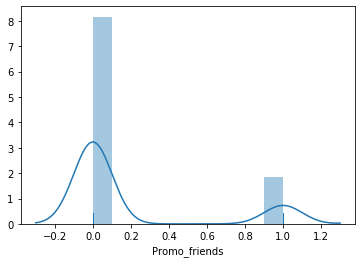

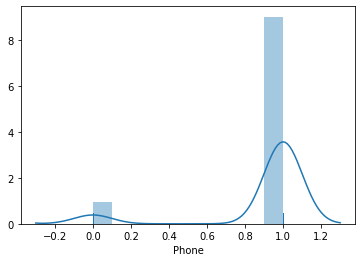

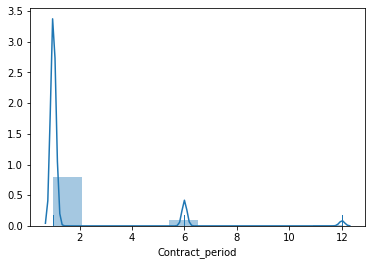

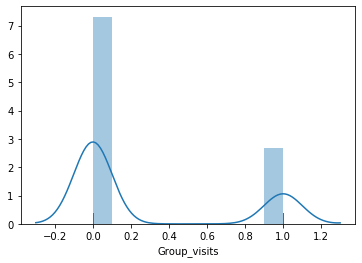

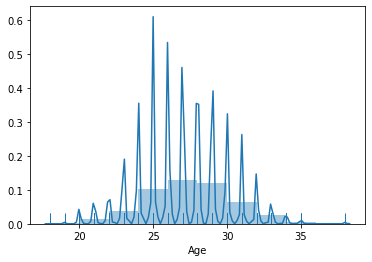

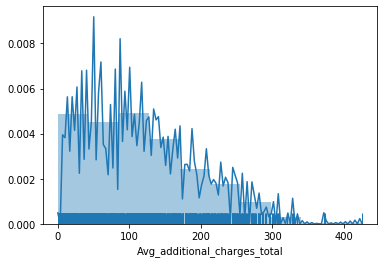

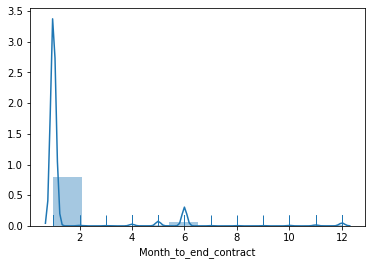

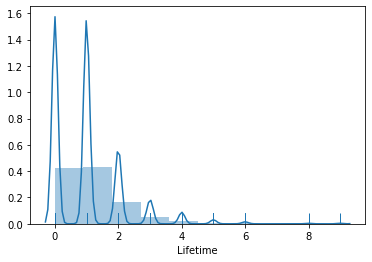

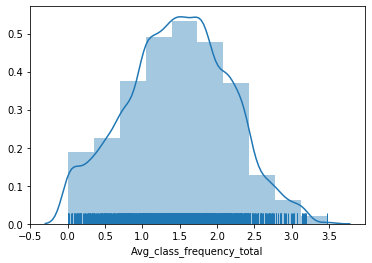

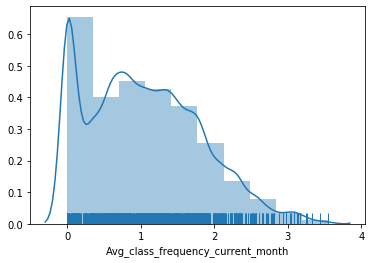

In [10]:
#построим столбчатые гистограммы для кто ушел
for col in churn_yes.drop('Churn',axis=1).columns:
    sns.distplot(churn_yes[col], bins = 10, rug=True, hist=True, kde_kws={'bw':0.1})
    plt.show()

У большинства убывших клиентов заканичавется срок абонемента. Лайфтайм также в большинстве случаев не превышает 2 месяцев. 

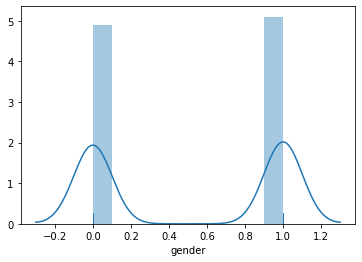

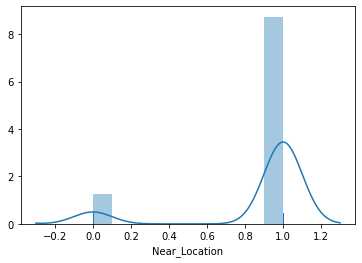

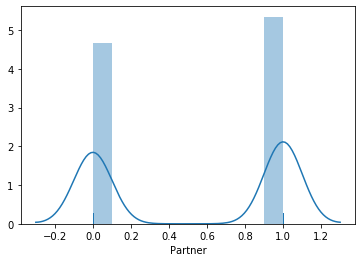

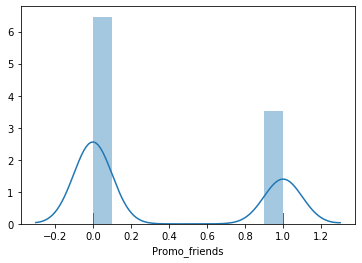

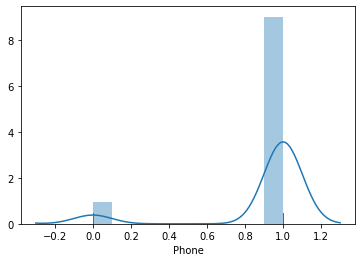

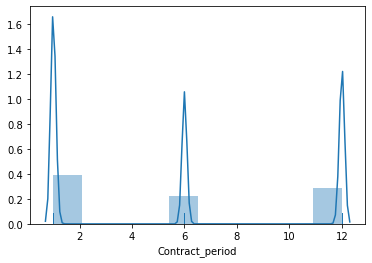

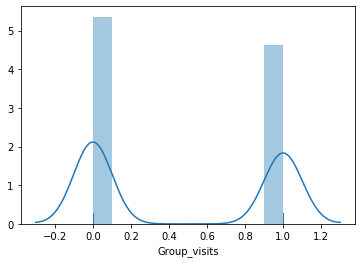

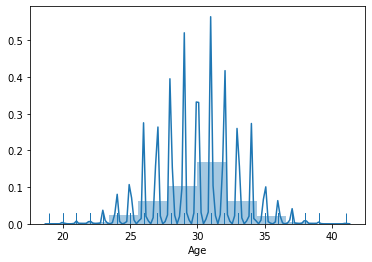

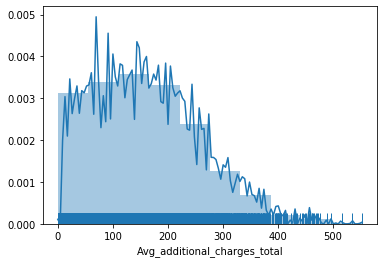

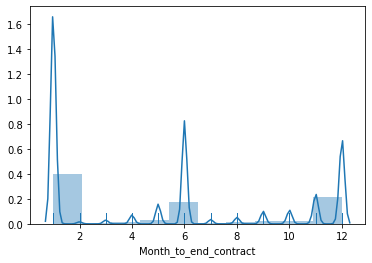

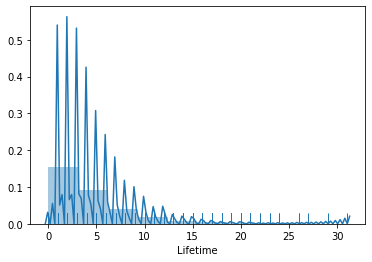

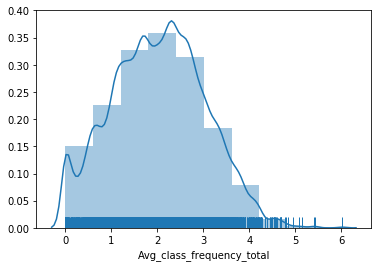

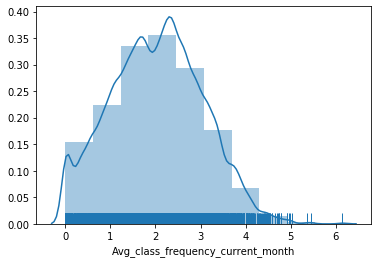

In [11]:
#построим столбчатые гистограммы для кто не ушел
for col in churn_not.drop('Churn',axis=1).columns:
    sns.distplot(churn_not[col], bins = 10, rug=True, hist=True, kde_kws={'bw':0.1})
    plt.show()

Весомым аргументом посещать фитнес-центр мы видим проживание или работа в районе, где он находится . Доля клиентов с годовым абонементом выше, чем те, у кого абонемент на полгода. Еженедельное посещение фитнес-центра приближается к 3 за неделю

## Матрица корреляций 

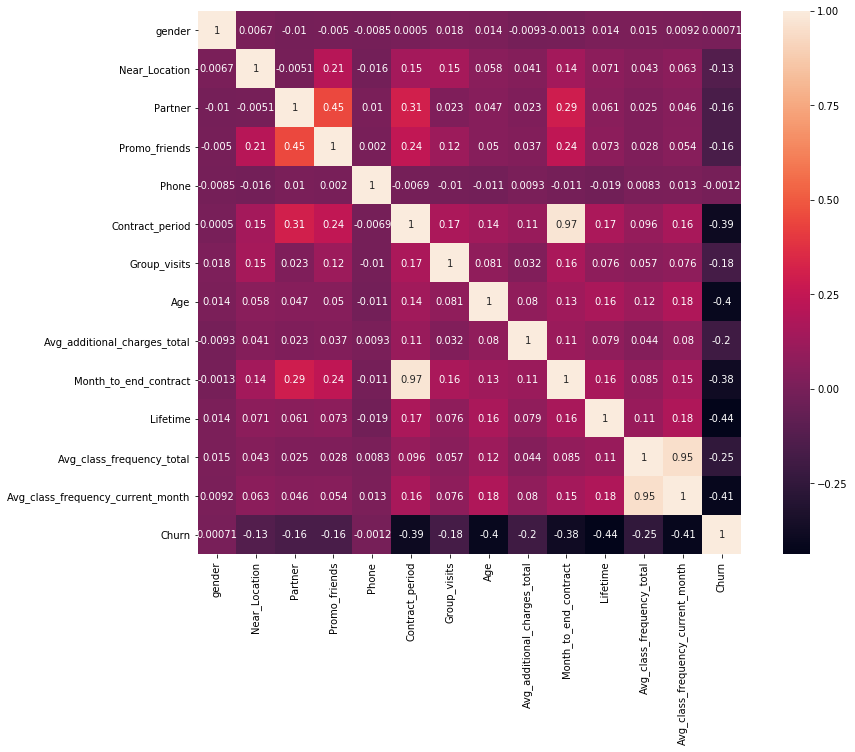

In [12]:
#построим и отрисуем матрицу корреляций
cm = gym.corr()
fig, ax = plt.subplots(figsize=(15,10))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot = True, square=True)
ax.set_ylim(14, 0)
plt.show()

1. Практически идентичная прямая зависимость между сроком до окончания текущего действующего абонемента и длительностью текущего действующего абонемента
2. Практически идентичная прямая зависимость между средней частотой посещений в неделю за все время с начала действия абонемента и средней частотой посещений в неделю за предыдущий месяц. Клиенты, как правило, посещают фитнес-центр в постоянном для себя режиме
3. Высокая прямая зависимость между сотрудниками компании-партнёров клуба и фактом первоначальной записи в рамках акции «приведи друга»(0.45). Привлечение новых сотрудников среди компаний-партнеров увеличивает эффективность промо-кода от знакомого при оплате первого абонемента
4. Высокая прямая зависимость между сотрудниками компании-партнёров клуба и длительностью текущего действующего абонемента(0.31). Рост среди новых клиентов между сотрудниками компании-партнёров увеличивает среднюю продолжительность абонемента
5. Также мы видим прямую зависимость среди тех, кто пришел по промо-коду и длительностью абонемента(0.24).Это лояльные для фитнес-клуба клиенты
6. Чем больше клиентов уходит в отток, тем ниже лайфтайм(-0.44). Новые клиенты не задерживаются в клубе
7. Чем больше клиентов уходит в отток, тем меньше они занимаются в неделю раз(-0.41). Клиенты со временем теряют интерес к походу в клуб
8. Есть обратная зависимость между оттоком клиентов и их возрастом(-0.4). Молодые клиенты чаще перестают ходить в клуб
9. Также уходят клиенты, у которых заканчивается период абонемента(-0.39). Клиенты не продлевают свои абонементы на новый период

----------
<font color="green">

## Комментарий от наставника

Второй шаг работы выполнен также безупречно. Двигаемся дальше)
    
</font>

# 3. Модель прогнозирования оттока пользователей
## Модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце:
###  Логистическая регрессия

In [13]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop('Churn', axis = 1)
y = gym['Churn']

In [14]:
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационный набор данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [16]:
# зададим алгоритм для нашей модели
model = LogisticRegression(random_state=0)

In [17]:
# обучим модель
model.fit(X_train_st,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
probabilities = model.predict_proba(X_test_st)[:,1]

In [19]:
# бинарный прогноз
predictions = model.predict(X_test_st)

In [20]:
# выведем все изученные метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, predictions)))

Accuracy: 0.92
Precision: 0.85
Recall: 0.83
F1: 0.84
ROC_AUC: 0.89


Высокая доля правильных ответов(Accuracy = 0.92). Достаточно высокая доля прогнозов относительно "1" класса(Precision = 0.85) и доля реальных объектов "1" класса(Recall = 0.83). Но, возможно стоит немного скорректировать метрики. Баланс между метриками также достаточно хороший(F1 = 0.84). Оценка качества модели классификации на хорошем уровне(ROC_AUC = 0.89)
Немного скорректируем порог классов(зададим threshold = 0.4)

In [21]:
# зададим порог
threshold = 0.4

# на основании вероятностей и соотношения классов рассчитаем predict
custom_predictions = [0 if i<threshold else 1 for i in probabilities]

# выведем все изученные метрики для прогноза по новому порогу
print('Метрики для прогноза с кастомным порогом')
print('Accuracy for custom: {:.2f}'.format(accuracy_score(y_test, custom_predictions)))
print('Precision for custom: {:.2f}'.format(precision_score(y_test, custom_predictions)))
print('Recall for custom: {:.2f}'.format(recall_score(y_test, custom_predictions)))
print('F1 for custom: {:.2f}'.format(f1_score(y_test, custom_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, predictions)))

Метрики для прогноза с кастомным порогом
Accuracy for custom: 0.92
Precision for custom: 0.82
Recall for custom: 0.86
F1 for custom: 0.84
ROC_AUC: 0.89


Мы видим небольшое снижение по точности прогноза(с 0.85 до 0.82) и по балансу среди метрик(с 0.84 до 0.83). Однако выросла приоритетная метрика recall(с 0.83 до 0.85). Также важная метрика ROC_AUC осталась неизменной
Имеет смысл использовать именно кастомную версию логистической регрессии

### Случайный Лес

In [22]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100)

In [23]:
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [25]:
# выведем все изученные метрики
print('Метрики для дерева принятия решения')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, rf_predictions)))

Метрики для дерева принятия решения
Accuracy: 0.91
Precision: 0.84
Recall: 0.80
F1: 0.82
ROC_AUC: 0.88


По сравнению с кастомной версией логистической регрессии, для модели "Случайного Леса" немного выше метрика precision(0.84 против 0.82), однако важнее, что recall ниже(0.83 против 0.85). Показатели остальных метрик равны
Ставя в приоритет recall, как метрику, показывающую долю реальных обьектов, предпочтительней использовать модель логистической регрессии с кастомным порогом(threshold = 0.4) 

----------
<font color="orange">

## Комментарий от наставника

С обучением моделей ты справился просто отлично. Для полного совершенства можно было бы сделать перебор гиперпараметров и кросс-валидацию.
Но в рамках данного проекта это не целевая задача.
    
</font>

# 4. Кластеризация пользователей

In [26]:
#Стандартизируйем данные
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
x_sc = scaler.fit_transform(gym.drop(columns = ['Churn'])) # обучаем нормализатор и преобразуем набор данных

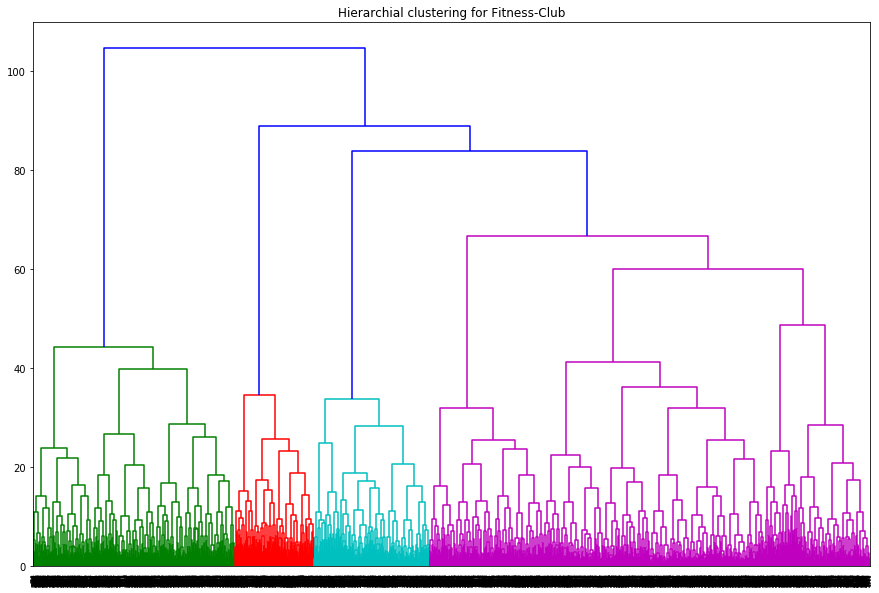

In [476]:
#Строим матрицу расстояний функцией linkage() на стандартизованной матрице признаков 
linked = linkage(x_sc, method = 'ward')
#рисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for Fitness-Club')
plt.show()

После кластеризации образовалось 4 кластера клиентов(договоримся за число кластеров принять n=5, согласно условию проекта, чтобы результаты можно было сравнивать с результатами остальных студентов)

----------
<font color="green">

## Комментарий от наставника

Кластеры построены корректно. Построим на обучение модели)
    
</font>

In [477]:
#Обучаем модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5)

In [478]:
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc)

In [479]:
# сохраняем метки кластера в поле нашего датасета
gym['Cluster'] = labels

In [480]:
# выводим статистику по средним значениям наших признаков по кластеру
gym_avg = gym.groupby('Cluster').mean()
gym_avg

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
Cluster,,,,,,,,,,,,,,
0,0.484424,0.998442,0.822430,1.000000,0.900312,3.155763,0.454829,29.218069,141.203442,2.919003,3.705607,1.734352,1.627826,0.247664
1,0.500534,0.945571,0.741729,0.486660,0.899680,11.871932,0.552828,29.933831,164.763165,10.865528,4.695838,2.001331,1.992684,0.022412
2,0.487365,1.000000,0.242780,0.020758,0.901625,1.981047,0.319495,28.219314,131.035017,1.900722,2.395307,1.273202,1.030240,0.527076
3,0.587240,0.971354,0.261719,0.092448,0.904948,2.820312,0.479167,30.130208,162.235991,2.591146,5.138021,2.882729,2.884871,0.067708
4,0.495413,0.000000,0.466055,0.077064,0.915596,2.227523,0.214679,28.484404,133.862709,2.091743,2.788991,1.656393,1.465891,0.449541


1. В нулевом кластере клиентов самый высокий отток(0.53), при этом все они проживают или работают в районе фитнес-центра. Они реже всего ходят в фитнес-центр(один раз в неделю), у них заканчивается абонемент(менее двух месяцев до конца)  
2. В первом кластере клиентов самые долгосрочные абонементы(12 месяцев) и самая высокая суммарная выручка от других услуг фитнес-центра(165). В большинстве это сотрудники компании-партнёров клуба(0.74). Половина пришла по промо-акции(0.49). При этом среди этих клиетов самый низкий отток(0.02)  
3. Второй кластер клиентов не проживает в районе, где расположен фитнес-клуб. Также для кластера низкий показатель промо-акции(0.08) и групповые занятия(0.22). И высокая доля оттока(0.45)
4. В третьем кластере клиентов, все пришли по промо-акции. Они проживают или работают в районе, где находится фитнес-центр и большая доля из них являются сотрудниками компании-партнёров клуба. 
5. Четвертый кластер клиентов самый перспективный. В нем самый большой лайфтайм(5 месяцев). Больше всего посещений фитнес-клуба в неделю(около трех раз). Очень низкий отток(0.07) и высокая суммарная выручка от других услуг фитнес-центра(162). При этом они не пришли по промо-коду и не являются партнерами фитнес-клуба, но живут или работают близко от него.

In [481]:
#Распределения признаков для кластеров
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (10,10))
    sns.scatterplot(df[x_name], df[y_name],
           hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

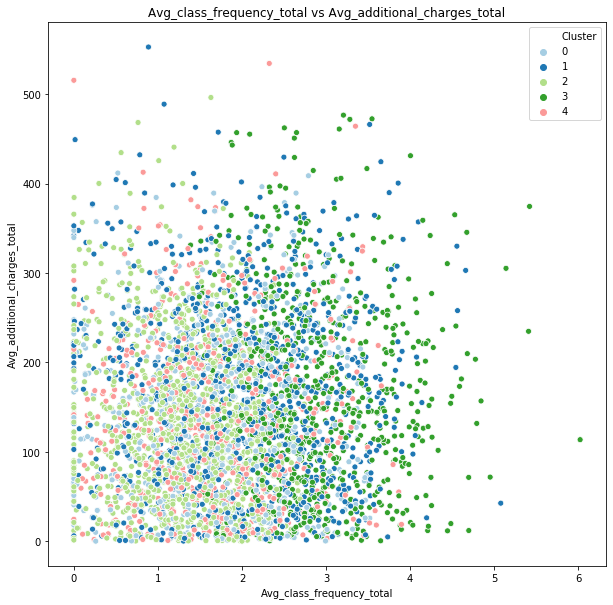

In [482]:
# отрисуем графики для пары признаков Средняя частота посещений в неделю за все время с начала действия абонемента 
# и Суммарная выручка от других услуг фитнес-центра
show_clusters_on_plot(gym, 'Avg_class_frequency_total', 'Avg_additional_charges_total', 'Cluster')

Для 4 кластера клиентов мы видим более высокую, чем у других кластеров посещаемость фитнес-клуба, при хорошей суммарной выручке от других услуг фитнес-центра. При этом, только среди этого кластера есть клиенты, которые ходят в клуб более 5 раз в неделю.
Первый кластер клиентов также имеет хорошие показатели посещаемости центра, при этом есть клиенты, которые тратят выше среднего показания на другие услуги фитнес-центра
Среди третьего кластера клиентов(те, кто пришли по промо-коду) есть высокие значения по выручке на услуги, но посещают центр они меньше, чем описаные выше кластеры. Очевидно, что в этом кластере есть и категория клиетов, готовых покупать дополнительные услуги, но также и тех, кто довольно быстро перестанет часто ходить и уйдет в отток

In [483]:
#Для каждого полученного кластера доля оттока 
gym.groupby('Cluster').agg({'Churn':'mean'}).sort_values(by='Churn',ascending=False)

,Churn
Cluster,
2,0.527076
4,0.449541
0,0.247664
3,0.067708
1,0.022412


Больше половины клиентов нулевого кластера ушли в отток(0.53). Также почти половина(0.45) клиентов ушли в отток во втором кластере. В четвертом и первом кластере показатель churn минимален(0.7 и 0.2 соответственно)

----------
<font color="green">

## Комментарий от наставника

Ты прекрасно проанализировал различия в кластерах и выявил наиболее склонные к оттоку. Посмотрим, как ты можешь дать рекомендации.
    
</font>

# 5. Выводы  

По сравнению с кастомной версией логистической регрессии, для модели "Случайного Леса" немного выше метрика precision(0.84 против 0.82), однако важнее, что recall ниже(0.83 против 0.85). Показатели остальных метрик равны.
Ставя в приоритет recall, как метрику, показывающую долю реальных обьектов, предпочтительней использовать модель логистической регрессии с кастомным порогом(threshold = 0.4) 

После кластеризации образовалось 4 кластера клиентов(договоримся за число кластеров принять n=5, согласно условию проекта, чтобы результаты можно было сравнивать с результатами остальных студентов)

В нулевом кластере клиентов самый высокий отток(0.53), при этом все они проживают или работают в районе фитнес-центра. Они реже всего ходят в фитнес-центр(один раз в неделю), у них заканчивается абонемент(менее двух месяцев до конца)

В первом кластере клиентов самые долгосрочные абонементы(12 месяцев) и самая высокая суммарная выручка от других услуг фитнес-центра(165). В большинстве это сотрудники компании-партнёров клуба(0.74). Половина пришла по промо-акции(0.49). При этом среди этих клиетов самый низкий отток(0.02)

Второй кластер клиентов не проживает в районе, где расположен фитнес-клуб. Также для кластера низкий показатель промо-акции(0.08) и групповые занятия(0.22). И высокая доля оттока(0.45)

В третьем кластере клиентов, все пришли по промо-акции. Они проживают или работают в районе, где находится фитнес-центр и большая доля из них являются сотрудниками компании-партнёров клуба.

Четвертый кластер клиентов самый перспективный. В нем самый большой лайфтайм(5 месяцев). Больше всего посещений фитнес-клуба в неделю(около трех раз). Очень низкий отток(0.07) и высокая суммарная выручка от других услуг фитнес-центра(162). При этом они не пришли по промо-коду и не являются партнерами фитнес-клуба, но живут или работают близко от него.

## Базовые рекомендации по работе с клиентами

Рассматривать приоритетными три кластера клиентов:
- Четвертый кластер клиентов чаще всех ходит в центр, при этом не являясь как правило сотрудником компании-партнёра клуба. Таких клиентов необходимо удерживать. Можно предложить для них программу лояльности для увеличения лайфтайма
- В первом кластере самые "прибыльные" клиенты. Среди них самая большая выручка и самые продолжительные абонементы.  Можно разработать для них акцию на дополнительные услуги фитнес-центра("Все включено")
- В третьем кластере клиентов, все пришли по промо-акции. Они проживают или работают в районе, где находится фитнес-центр и большая доля из них являются сотрудниками компании-партнёров клуба. Можно предложить им продолжить флаер-компанию. За приведенного друга они получат скидку на абонемент

----------
<font color="green">

## Комментарий от наставника

У тебя получились осмысленные рекомендации и хороший проект. Не вижу препятствий чтобы поставить зачет с первого раза)
    
</font>